In [1]:
from os import path
import numpy as np
import pandas as pd
import natsort
import glob
import cv2
import os
import tifffile as tiff
import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure
import scipy.io
import anndata
from skimage.transform import warp
from skimage.draw import polygon
from PIL import Image
import seaborn as sns
import dask.array as da
import imagecodecs
import math
import skimage
from skimage import transform
import scanpy as sc
from scipy.sparse import issparse
from scipy.stats import linregress
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from IPython.display import display

# Track Cell Analysis

In [4]:
folder = "/scratch/welchjd_root/welchjd2/shared_data/Xenium_0421_Lyso/Track_Cell_Result"
all_files = glob.glob(os.path.join(folder, "Field*_track_cell.csv"))
all_files.sort()

df_list = []
for f in all_files:
    df = pd.read_csv(f)
    df_list.append(df)
combined = pd.concat(df_list, ignore_index=True)
combined['positions_out_cell'] = combined['total_positions'] - combined['positions_in_cell']
combined = combined[
    (combined['positions_in_cell'] > 2) &
    (combined['positions_out_cell'] > 2) &
    (combined['total_positions'] > 5)
]

/tmp/ipykernel_1329116/3009959699.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(df_list, ignore_index=True)


In [5]:
combined

,TRACK_ID,cell_id,positions_in_cell,total_positions,TRACK_INDEX,NUMBER_SPOTS,NUMBER_GAPS,NUMBER_SPLITS,NUMBER_MERGES,NUMBER_COMPLEX,...,TRACK_STD_SPEED,TRACK_MEAN_QUALITY,TOTAL_DISTANCE_TRAVELED,MAX_DISTANCE_TRAVELED,CONFINEMENT_RATIO,MEAN_STRAIGHT_LINE_SPEED,LINEARITY_OF_FORWARD_PROGRESSION,MEAN_DIRECTIONAL_CHANGE_RATE,FOV,positions_out_cell
1,39,bmeaflam-1,9,21,39,21,0,0,0,0,...,0.034830,139.588960,0.390646,0.157730,0.350778,0.006851,0.350778,1.290110,1,12
3,43,bmehfmbl-1,8,50,43,50,0,0,0,0,...,0.008074,139.385289,0.380153,0.183330,0.455376,0.003533,0.455376,1.046658,1,42
4,43,bmejpdaj-1,42,50,43,50,0,0,0,0,...,0.008074,139.385289,0.380153,0.183330,0.455376,0.003533,0.455376,1.046658,1,8
6,51,bmejpdaj-1,21,40,51,40,0,0,0,0,...,0.029394,378.429841,0.683258,0.304597,0.445801,0.007810,0.445801,1.858211,1,19
7,272,bmejpdaj-1,5,15,272,15,0,0,0,0,...,0.026370,197.360077,0.227862,0.171209,0.751369,0.012229,0.751369,1.561646,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261648,4361,gocmnlci-1,9,14,4361,14,0,0,0,0,...,0.031759,52.584036,0.205440,0.129442,0.562164,0.008884,0.562164,1.762969,464,5
261653,4453,ackoiddm-1,5,10,4453,10,1,0,0,0,...,0.019346,6.887331,0.283934,0.088574,0.230739,0.006551,0.222528,1.402091,464,5
261654,4453,gmpmgchh-1,5,10,4453,10,1,0,0,0,...,0.019346,6.887331,0.283934,0.088574,0.230739,0.006551,0.222528,1.402091,464,5
261655,4457,gmpkndjl-1,8,11,4457,11,1,0,0,0,...,0.043206,9.640182,0.351290,0.219336,0.624372,0.019940,0.571013,1.486425,464,3


In [6]:
combined.columns

Index(['TRACK_ID', 'cell_id', 'positions_in_cell', 'total_positions',
       'TRACK_INDEX', 'NUMBER_SPOTS', 'NUMBER_GAPS', 'NUMBER_SPLITS',
       'NUMBER_MERGES', 'NUMBER_COMPLEX', 'LONGEST_GAP', 'TRACK_DURATION',
       'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT', 'TRACK_X_LOCATION',
       'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'TRACK_MEAN_SPEED',
       'TRACK_MAX_SPEED', 'TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED',
       'TRACK_STD_SPEED', 'TRACK_MEAN_QUALITY', 'TOTAL_DISTANCE_TRAVELED',
       'MAX_DISTANCE_TRAVELED', 'CONFINEMENT_RATIO',
       'MEAN_STRAIGHT_LINE_SPEED', 'LINEARITY_OF_FORWARD_PROGRESSION',
       'MEAN_DIRECTIONAL_CHANGE_RATE', 'FOV', 'positions_out_cell'],
      dtype='object')

In [5]:
per_cell = (
    combined
      .groupby("cell_id")[["TRACK_MEAN_SPEED","TRACK_DISPLACEMENT","TOTAL_DISTANCE_TRAVELED",
          "CONFINEMENT_RATIO","LINEARITY_OF_FORWARD_PROGRESSION","MEAN_DIRECTIONAL_CHANGE_RATE"]]
      .mean()
      .rename(columns={
          "TRACK_MEAN_SPEED":"mean_speed_per_cell","TRACK_DISPLACEMENT":"mean_displacement_per_cell",
          "TOTAL_DISTANCE_TRAVELED":"mean_total_distance_per_cell","CONFINEMENT_RATIO":"mean_confinement_ratio",
          "LINEARITY_OF_FORWARD_PROGRESSION":"mean_linearity_of_forward_progression",
          "MEAN_DIRECTIONAL_CHANGE_RATE":"mean_directional_change_rate",}))
per_cell["track_count"] = (combined.groupby("cell_id")["TRACK_ID"].nunique())
for col in list(per_cell.columns):per_cell[f"log1p_{col}"] = np.log1p(per_cell[col])

In [8]:
per_cell

,mean_speed_per_cell,mean_displacement_per_cell,mean_total_distance_per_cell,mean_confinement_ratio,mean_linearity_of_forward_progression,mean_directional_change_rate,track_count,log1p_mean_speed_per_cell,log1p_mean_displacement_per_cell,log1p_mean_total_distance_per_cell,log1p_mean_confinement_ratio,log1p_mean_linearity_of_forward_progression,log1p_mean_directional_change_rate,log1p_track_count
cell_id,,,,,,,,,,,,,,
aaagpdno-1,0.015665,0.143024,0.760086,0.188169,0.186335,1.187123,1,0.015543,0.133678,0.565362,0.172413,0.170869,0.782587,0.693147
aaahmode-1,0.018716,0.164748,0.625728,0.316602,0.318397,1.375151,9,0.018543,0.152505,0.485956,0.275054,0.276416,0.865061,2.302585
aaakopaf-1,0.009309,0.170045,0.456140,0.372791,0.372791,2.071918,1,0.009266,0.157042,0.375789,0.316846,0.316846,1.122302,0.693147
aabeccgk-1,0.016186,0.198497,0.505322,0.471470,0.489439,1.411955,7,0.016056,0.181068,0.409007,0.386262,0.398399,0.880437,2.079442
aabedijc-1,0.015982,0.255324,0.542654,0.470509,0.469878,1.942344,1,0.015855,0.227393,0.433504,0.385609,0.385179,1.079207,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oijnhbgd-1,0.015538,0.111793,0.407954,0.289636,0.293285,1.567918,5,0.015419,0.105974,0.342137,0.254360,0.257186,0.943096,1.791759
oijooanl-1,0.012186,0.137632,0.489384,0.281116,0.294688,1.464643,2,0.012112,0.128949,0.398362,0.247731,0.258269,0.902047,1.098612
oijooeoi-1,0.013186,0.136169,0.224169,0.607440,0.607440,1.045955,1,0.013100,0.127662,0.202262,0.474643,0.474643,0.715865,0.693147


In [9]:
per_cell.columns

Index(['mean_speed_per_cell', 'mean_displacement_per_cell',
       'mean_total_distance_per_cell', 'mean_confinement_ratio',
       'mean_linearity_of_forward_progression', 'mean_directional_change_rate',
       'track_count', 'log1p_mean_speed_per_cell',
       'log1p_mean_displacement_per_cell',
       'log1p_mean_total_distance_per_cell', 'log1p_mean_confinement_ratio',
       'log1p_mean_linearity_of_forward_progression',
       'log1p_mean_directional_change_rate', 'log1p_track_count'],
      dtype='object')

In [6]:
adata_xenium = sc.read_10x_h5(
    filename="/nfs/turbo/umms-welchjd/Xenium/4_21_CRISPRi_iNeuron_Lysosome/20250423__165636__13369-KL/output-XETG00495__0040384__13369-KL-1_ROI_A__20250423__165643/cell_feature_matrix.h5"
)
adata_xenium.obs['total_counts'] = (
        adata_xenium.X.sum(axis=1).A1          # .A1 flattens sparse → 1-D np.array
        if hasattr(adata_xenium.X, "A1")       # sparse matrix has .A1
        else adata_xenium.X.sum(axis=1)        # dense ndarray
    )
adata_xenium.obs['total_counts'] = adata_xenium.X.sum(axis=1).A1
num_cells_800 = (adata_xenium.obs['total_counts'] >= 800).sum()
adata_filtered = adata_xenium[adata_xenium.obs['total_counts'] >= 800].copy()
sgRNA_genes = [gene for gene in adata_filtered.var_names if '-' in gene and not 'HLA' in gene]
sgRNA_to_target = {sg: sg.split('-')[0] for sg in sgRNA_genes}

idxs = [adata_filtered.var_names.get_loc(g) for g in sgRNA_genes]
mat = adata_filtered.X[:, idxs]
if issparse(mat):
    mat = mat.toarray()
bin_mat = (mat > 0).astype(int)
df_ind = pd.DataFrame(
    bin_mat,
    index=adata_filtered.obs_names,
    columns=[g for g in sgRNA_genes]
)
adata_filtered.obs = adata_filtered.obs.join(df_ind)

obs_clean = adata_filtered.obs.drop(columns=["total_counts"], errors="ignore")
gene_cols = [g for g in sgRNA_genes if g in obs_clean.columns]

counts = obs_clean[gene_cols].sum(axis=0).sort_values(ascending=False)
counts_df = pd.DataFrame({
    "gene":  counts.index,
    "count": counts.values
})
counts_df["rank"] = counts_df["count"].rank(ascending=False, method="dense")

top4 = counts_df.loc[:3, 'gene'].tolist()
remaining = [
    col for col in adata_filtered.obs.columns
    if col not in top4 + ['total_counts']
]
adata_filtered.obs['sgRNA_Gene_count'] = (
    adata_filtered.obs[remaining].sum(axis=1)
)
adata_filtered.obs['perturbation'] = np.where(
    adata_filtered.obs['sgRNA_Gene_count'] > 0,
    'perturbed',
    'unperturbed'
)
cell_perturb_ind = adata_filtered.obs.copy()[['sgRNA_Gene_count', 'perturbation']]

In [7]:
top4

['ID2-4', 'SOX5-3', 'NFIB-2', 'ID2-2']

In [8]:
obs = adata_filtered.obs[remaining]
sgRNA_cols = [col for col in obs.columns if "-" in col]

gene_names = sorted({col.split("-", 1)[0] for col in sgRNA_cols})
perturb_df = pd.DataFrame(index=obs.index, columns=gene_names, dtype="object")

for gene in gene_names:
    matching_cols = [col for col in sgRNA_cols if col.startswith(gene + "-")]
    if not matching_cols:
        continue

    sub_df = obs[matching_cols]
    any_positive = (sub_df > 0).any(axis=1)
    perturb_df[gene] = any_positive.map({True: "perturbed", False: "unperturbed"})
print("First few rows of perturb_df:")
print(perturb_df.iloc[:5, :5])
for gene in gene_names:
    colname = f"{gene}_perturb_status"
    adata_filtered.obs[colname] = perturb_df[gene]


First few rows of perturb_df:
                   AFF1         BCL6         BNC2      CARHSP1        CREB5
aaadneob-1  unperturbed  unperturbed  unperturbed  unperturbed  unperturbed
aaahmode-1    perturbed  unperturbed  unperturbed  unperturbed  unperturbed
aaahnoof-1  unperturbed  unperturbed  unperturbed  unperturbed  unperturbed
aaajgnge-1  unperturbed  unperturbed  unperturbed  unperturbed  unperturbed
aaaohebe-1  unperturbed  unperturbed  unperturbed  unperturbed  unperturbed


In [16]:
perturb_df

,AFF1,BCL6,BNC2,CARHSP1,CREB5,EBF1,EBF3,HMGB2,ID2,ID4,...,NFE2L2,NFIB,Negative_control,ONECUT1,ONECUT2,PROX1,RUNX1,SIX1,SOX5,ZBTB7C
aaadneob-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
aaahmode-1,perturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
aaahnoof-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
aaajgnge-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
aaaohebe-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,perturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ognbimnl-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,perturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
ognedldd-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,perturbed,unperturbed,unperturbed,unperturbed,unperturbed
ognfbmkg-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,perturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed
ohljelgh-1,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,...,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed,unperturbed


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

alpha = 0.05

metrics_df = per_cell.reset_index().rename(columns={'index':'cell_id'})
perturb2   = perturb_df.reset_index().rename(columns={'index':'cell_id'})
df_all     = metrics_df.merge(perturb2, on='cell_id', how='inner')

metric_cols = [
    "mean_speed_per_cell", "mean_displacement_per_cell", "mean_total_distance_per_cell",
    "mean_confinement_ratio", "mean_linearity_of_forward_progression", "mean_directional_change_rate",
    "track_count", "log1p_mean_speed_per_cell", "log1p_mean_displacement_per_cell",
    "log1p_mean_total_distance_per_cell", "log1p_mean_confinement_ratio",
    "log1p_mean_linearity_of_forward_progression", "log1p_mean_directional_change_rate",
    "log1p_track_count"
]
perturb_cols = perturb_df.columns.tolist()

df_long = df_all.melt(
    id_vars=['cell_id'] + metric_cols,
    value_vars=perturb_cols,
    var_name='gene',
    value_name='perturbation'
)
df_long = df_long[df_long['perturbation']=='perturbed'].copy()

genes = df_long['gene'].unique().tolist()
p_vals = []
for col in metric_cols:
    samples = [df_long.loc[df_long['gene']==g, col].dropna().values for g in genes]
    _, p = kruskal(*samples)
    p_vals.append(p)

rej, p_adj, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

pretty = {
    "mean_speed_per_cell":               "Mean Speed",
    "mean_displacement_per_cell":        "Mean Displacement",
    "mean_total_distance_per_cell":      "Mean Total Distance",
    "mean_confinement_ratio":            "Mean Confinement Ratio",
    "mean_linearity_of_forward_progression": "Mean Linearity of Forward Prog.",
    "mean_directional_change_rate":      "Mean Directional Change Rate",
    "track_count":                       "Track Count",
    "log1p_mean_speed_per_cell":         "Log1p Mean Speed",
    "log1p_mean_displacement_per_cell":  "Log1p Mean Displacement",
    "log1p_mean_total_distance_per_cell":"Log1p Mean Total Distance",
    "log1p_mean_confinement_ratio":      "Log1p Mean Confinement Ratio",
    "log1p_mean_linearity_of_forward_progression":"Log1p Mean Linearity of Forward Prog.",
    "log1p_mean_directional_change_rate":"Log1p Mean Directional Change Rate",
    "log1p_track_count":                 "Log1p Track Count",
}

print("Metric                           raw p-value    BH-adjusted p-value")
print("---------------------------------------------------------------")
for col, p_raw, p_a in zip(metric_cols, p_vals, p_adj):
    print(f"{pretty[col]:<35} {p_raw:>10.3e}     {p_a:>10.3e}")

signif_metrics = [col for col, sig in zip(metric_cols, rej) if sig]

for col in signif_metrics:
    print(f"\n\n=== Metric: {pretty[col]} (post-hoc vs. Negative_control) ===")
    temp = df_long[['gene', col]].copy()

    post_p = []
    stats  = []
    for g in genes:
        if g == 'Negative_control': continue
        a = temp.loc[temp['gene']==g, col].values
        b = temp.loc[temp['gene']=='Negative_control', col].values
        u, p = mannwhitneyu(a, b, alternative='two-sided')
        post_p.append(p)
        stats.append((g, a.mean(), b.mean(), u))

    rej2, p_adj2, _, _ = multipletests(post_p, alpha=alpha, method='fdr_bh')
    print("Gene         mean_pr    mean_ctrl    raw p     adj p    higher")
    print("----------------------------------------------------------------")
    for (g, mpr, mnc, u), p2, sig in zip(stats, post_p, rej2):
        arrow = '↑' if mpr > mnc else '↓'
        print(f"{g:<12} {mpr:8.3f}    {mnc:8.3f}  {p2:8.3e}  {p_adj2[stats.index((g,mpr,mnc,u))]:8.3e}    {arrow}")

    plt.figure(figsize=(12,6))
    data = [temp.loc[temp['gene']==g, col].dropna() for g in genes]
    plt.boxplot(data, labels=genes, patch_artist=True, showmeans=True,
                meanprops=dict(marker='x', markersize=8))
    plt.xticks(rotation=90)
    plt.title(f"{pretty[col]} by perturbation")
    plt.ylabel(pretty[col])
    plt.tight_layout()
    plt.show()


Metric                           raw p-value    BH-adjusted p-value
---------------------------------------------------------------
Mean Speed                           5.248e-01      6.571e-01
Mean Displacement                    4.917e-02      3.442e-01
Mean Total Distance                  1.402e-01      3.532e-01
Mean Confinement Ratio               6.571e-01      6.571e-01
Mean Linearity of Forward Prog.      6.230e-01      6.571e-01
Mean Directional Change Rate         3.675e-01      6.431e-01
Track Count                          1.514e-01      3.532e-01
Log1p Mean Speed                     5.248e-01      6.571e-01
Log1p Mean Displacement              4.917e-02      3.442e-01
Log1p Mean Total Distance            1.402e-01      3.532e-01
Log1p Mean Confinement Ratio         6.571e-01      6.571e-01
Log1p Mean Linearity of Forward Prog.  6.230e-01      6.571e-01
Log1p Mean Directional Change Rate   3.675e-01      6.431e-01
Log1p Track Count                    1.514e-01      3.532e-0

  gene                       metric  n_perturbed  n_control  mean_perturbed  mean_control  t_p_raw  t_p_adj  u_p_raw  u_p_adj
  BCL6             TRACK_MEAN_SPEED         2627       3626        0.020011      0.020905 0.002546 0.033020 0.006895 0.055159
  BCL6           TRACK_DISPLACEMENT         2627       3626        0.169762      0.177576 0.002248 0.032644 0.004587 0.050328
  BCL6      TOTAL_DISTANCE_TRAVELED         2627       3626        0.600997      0.625813 0.004235 0.043557 0.011174 0.076623
  BNC2      TOTAL_DISTANCE_TRAVELED         2445       3588        0.596789      0.624161 0.001966 0.032644 0.005915 0.053234
  EBF1      TOTAL_DISTANCE_TRAVELED         2850       3609        0.596066      0.622887 0.001420 0.032644 0.003458 0.050328
  EBF1 MEAN_DIRECTIONAL_CHANGE_RATE         2850       3609        1.586382      1.618781 0.000079 0.005685 0.000011 0.001651
   ID2             TRACK_MEAN_SPEED         1695       3665        0.019756      0.020858 0.001239 0.032644 0.003934 0

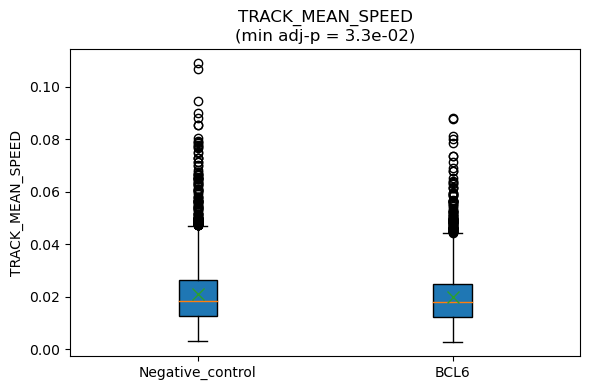

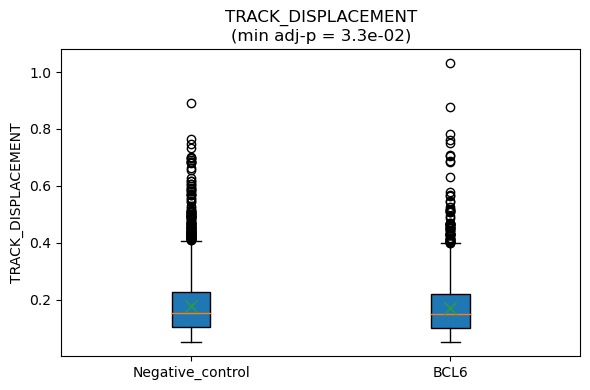

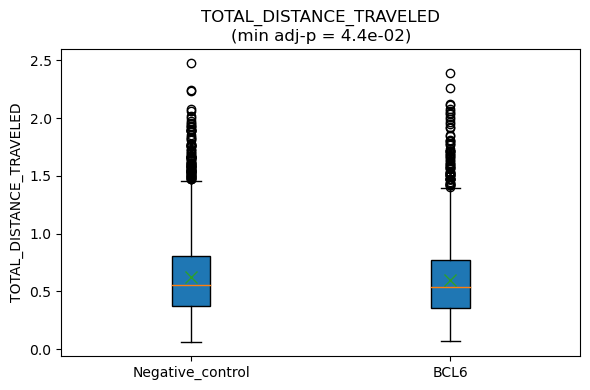

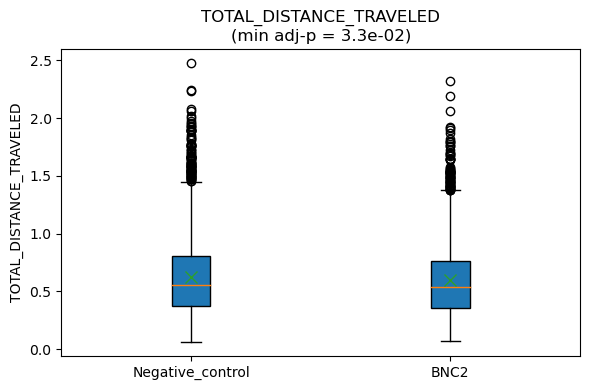

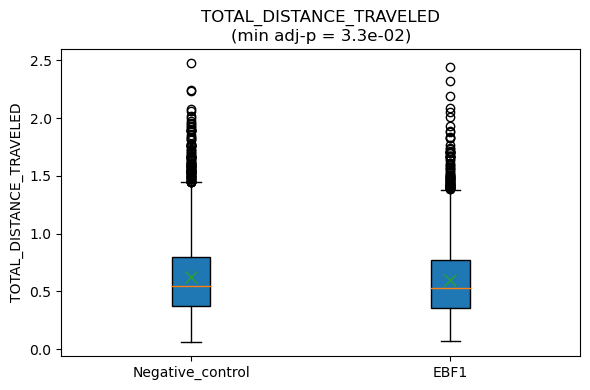

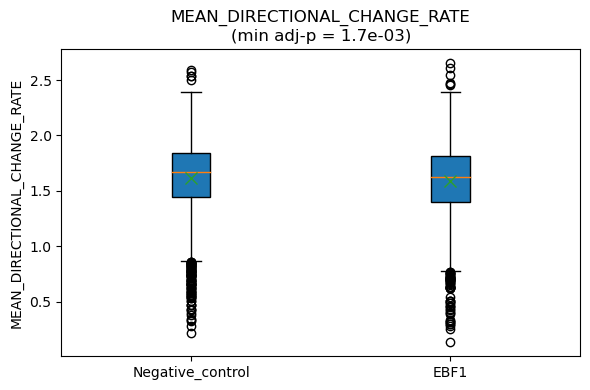

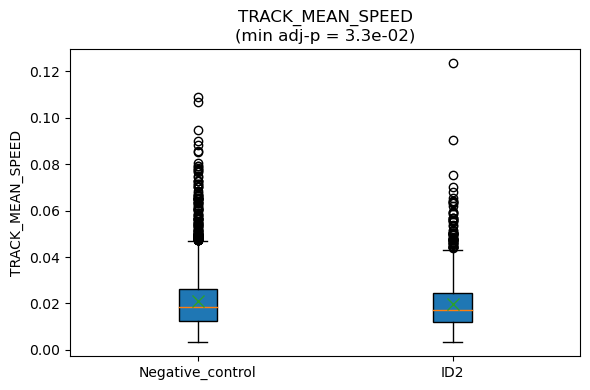

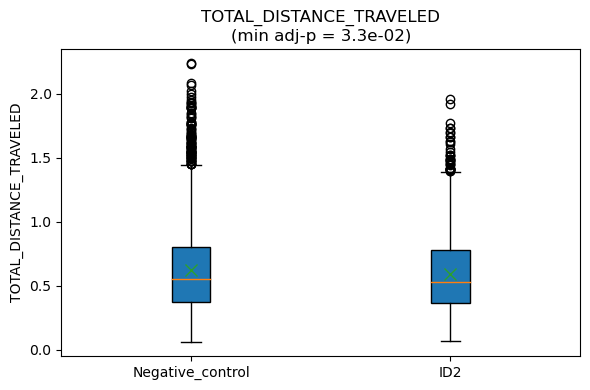

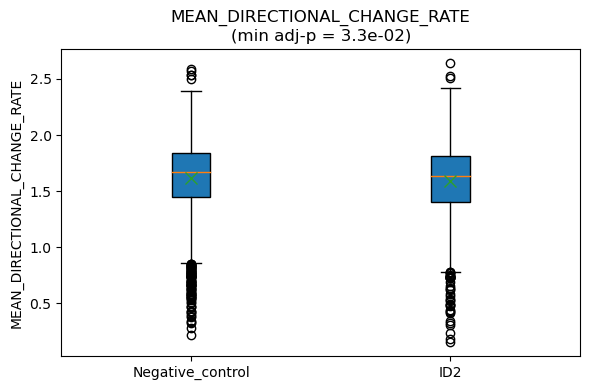

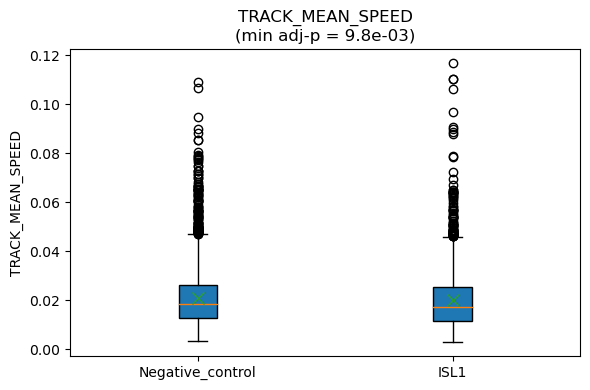

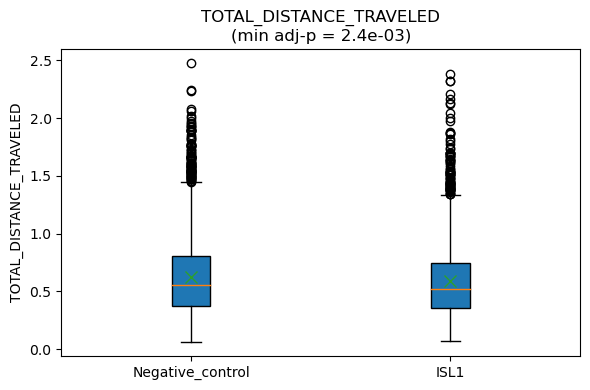

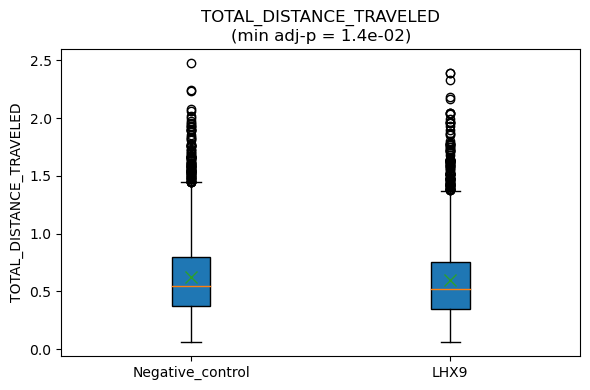

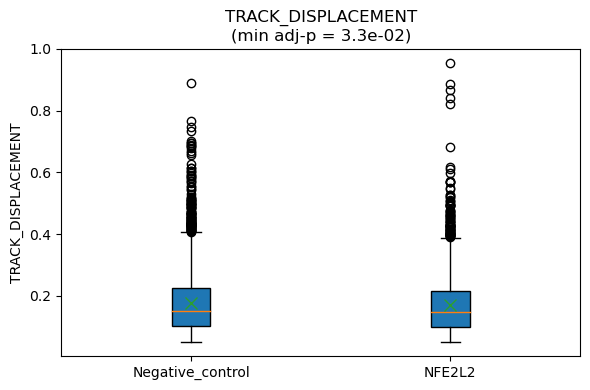

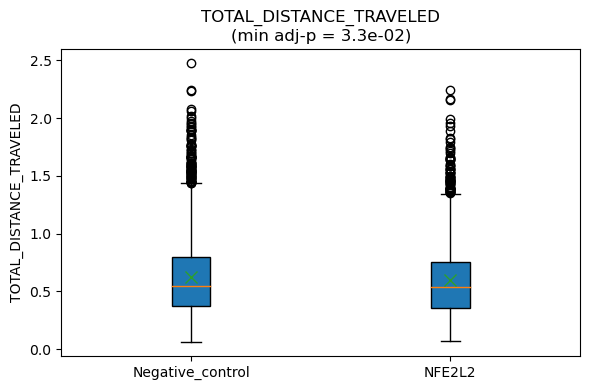

In [9]:
metrics = [
    "TRACK_MEAN_SPEED",
    "TRACK_DISPLACEMENT",
    "TOTAL_DISTANCE_TRAVELED",
    "CONFINEMENT_RATIO",
    "LINEARITY_OF_FORWARD_PROGRESSION",
    "MEAN_DIRECTIONAL_CHANGE_RATE"
]
genes = [g for g in perturb_df.columns if g != "Negative_control"]
alpha = 0.05

df_all = combined.merge(
    perturb_df,
    left_on="cell_id",
    right_index=True,
    how="inner"
)

records = []
for gene in genes:
    sub = df_all[
        ((df_all[gene] == "perturbed") | (df_all["Negative_control"] == "perturbed"))
        & ~((df_all[gene] == "perturbed") & (df_all["Negative_control"] == "perturbed"))
    ]
    for col in metrics:
        a = sub.loc[sub[gene] == "perturbed", col].dropna().values
        b = sub.loc[sub["Negative_control"] == "perturbed", col].dropna().values
        
        n_pr, n_nc = len(a), len(b)
        mean_pr = a.mean() if n_pr else np.nan
        mean_nc = b.mean() if n_nc else np.nan
        
        _, t_p = ttest_ind(a, b, nan_policy="omit", equal_var=True)
        _, u_p = mannwhitneyu(a, b, alternative="two-sided")
        
        records.append({
            "gene": gene,
            "metric": col,
            "n_perturbed": n_pr,
            "n_control": n_nc,
            "mean_perturbed": mean_pr,
            "mean_control": mean_nc,
            "t_p_raw": t_p,
            "u_p_raw": u_p
        })

results = pd.DataFrame.from_records(records)

results["t_p_adj"] = multipletests(results["t_p_raw"], alpha=alpha, method="fdr_bh")[1]
results["u_p_adj"] = multipletests(results["u_p_raw"], alpha=alpha, method="fdr_bh")[1]

mask = (results["t_p_adj"] < alpha) | (results["u_p_adj"] < alpha)
sig = results[mask].copy()

if sig.empty:
    print("No significant gene–metric comparisons found.")
else:
    print(sig.to_string(index=False, columns=[
        "gene", "metric", "n_perturbed", "n_control",
        "mean_perturbed","mean_control",
        "t_p_raw","t_p_adj","u_p_raw","u_p_adj"
    ]))

for _, row in sig.iterrows():
    gene = row["gene"]
    col  = row["metric"]
    smallest_p = min(row["t_p_adj"], row["u_p_adj"])
    
    sub = df_all[
        ((df_all[gene] == "perturbed") | (df_all["Negative_control"] == "perturbed"))
        & ~((df_all[gene] == "perturbed") & (df_all["Negative_control"] == "perturbed"))
    ]
    data_pr = sub.loc[sub[gene] == "perturbed", col]
    data_nc = sub.loc[sub["Negative_control"] == "perturbed", col]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.boxplot(
        [data_nc, data_pr],
        labels=["Negative_control", gene],
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker="x", markersize=8)
    )
    ax.grid(False)
    ax.set_title(f"{col}\n(min adj-p = {smallest_p:.1e})")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


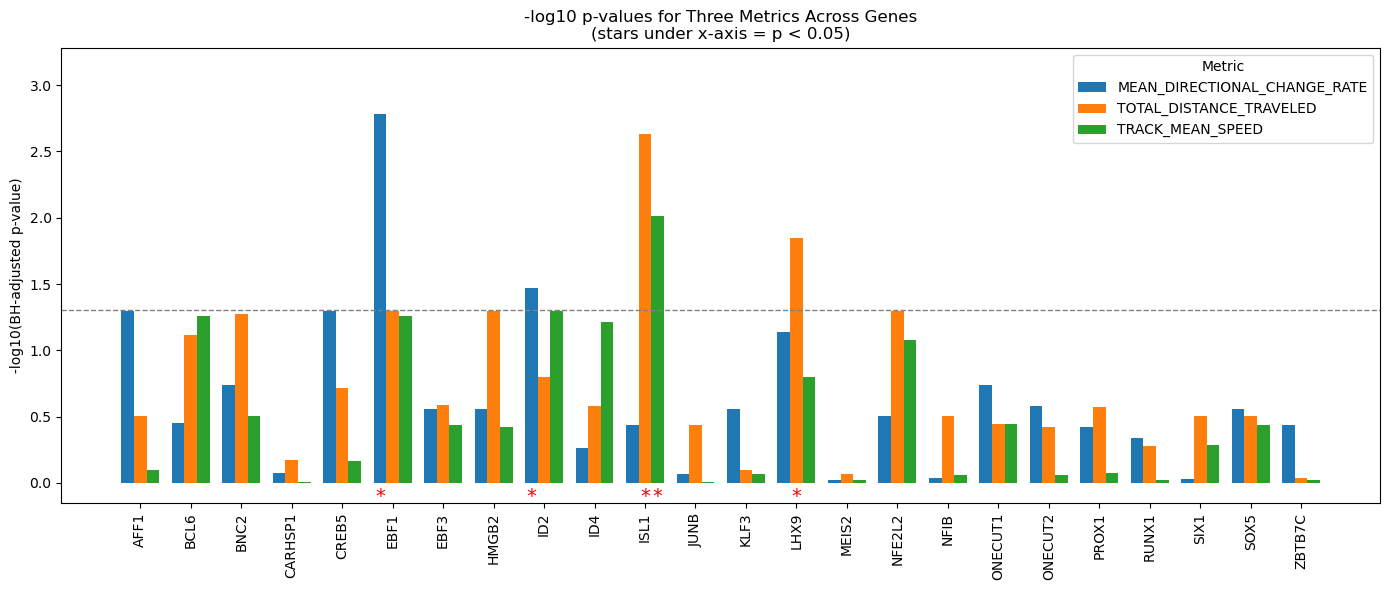

In [30]:

metrics3 = ["MEAN_DIRECTIONAL_CHANGE_RATE", "TOTAL_DISTANCE_TRAVELED", "TRACK_MEAN_SPEED"]
alpha    = 0.05
df3   = results[results["metric"].isin(metrics3)]
pivot = df3.pivot(index="gene", columns="metric", values="u_p_adj")[metrics3]

neglog = -np.log10(pivot)
genes = pivot.index.tolist()
x     = np.arange(len(genes))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
for i, metric in enumerate(metrics3):
    ax.bar(
        x + i*width,
        neglog[metric],
        width,
        label=metric
    )

threshold = -np.log10(alpha)
ax.axhline(threshold, color="gray", linestyle="--", linewidth=1)

ax.set_ylim(-0.15, neglog.values.max() + 0.5)

for i, metric in enumerate(metrics3):
    for j, gene in enumerate(genes):
        p = pivot.loc[gene, metric]
        if p < alpha:
            xpos = x[j] + i*width
            ax.text(
                xpos,
                -0.1,
                "*",
                ha="center",
                va="center",
                color="red",
                fontsize=14
            )

ax.set_xticks(x + width)
ax.set_xticklabels(genes, rotation=90)
ax.set_ylabel("-log10(BH-adjusted p-value)")
ax.set_title("-log10 p-values for Three Metrics Across Genes\n(stars under x-axis = p < 0.05)")
ax.legend(title="Metric")
plt.tight_layout()

#fig.savefig("barplot_3metrics_neglogp_stars_under_xaxis.png", dpi=300, bbox_inches="tight")
plt.show()


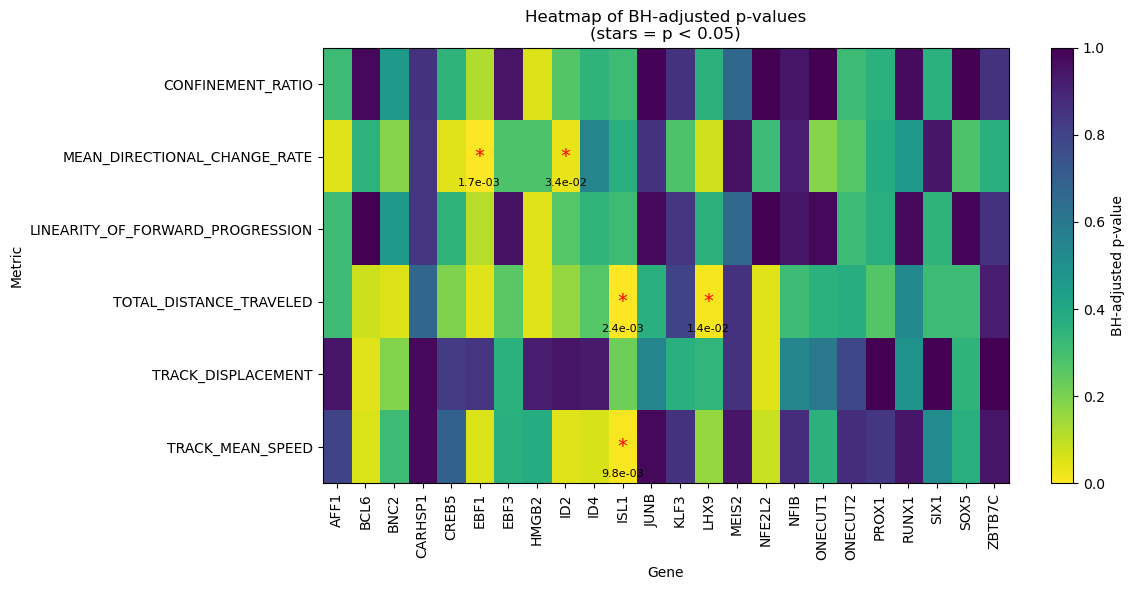

In [14]:
desired_order = [
    "CONFINEMENT_RATIO",
    "MEAN_DIRECTIONAL_CHANGE_RATE",
    "LINEARITY_OF_FORWARD_PROGRESSION",
    "TOTAL_DISTANCE_TRAVELED",
    "TRACK_DISPLACEMENT",
    "TRACK_MEAN_SPEED",
]
heatmap_data = results.pivot(index='metric', columns='gene', values='u_p_adj')

heatmap_data = heatmap_data.loc[desired_order]
sig_mask     = (heatmap_data < alpha)

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(
    heatmap_data,
    aspect='auto',
    cmap='viridis_r',
    vmin=0, vmax=1
)
plt.colorbar(im, label='BH-adjusted p-value')

ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=90)
ax.set_yticks(np.arange(len(desired_order)))
ax.set_yticklabels(desired_order)

for i in range(len(desired_order)):
    for j in range(heatmap_data.shape[1]):
        pval = heatmap_data.iat[i, j]
        if pval < alpha:
            ax.text(j, i, '*', ha='center', va='center',
                    color='red', fontsize=14)
            ax.text(j, i + 0.3, f"{pval:.1e}",
                    ha='center', va='top', color='black',
                    fontsize=8)

ax.set_title('Heatmap of BH-adjusted p-values\n(stars = p < 0.05)')
ax.set_xlabel('Gene')
ax.set_ylabel('Metric')
plt.tight_layout()
#fig.savefig("heatmap_with_stars_and_pvals.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
sig_u = results[results["u_p_adj"] < alpha].copy()
sig_u_display = sig_u.copy()

sig_u_display["n_perturbed"] = sig_u_display["n_perturbed"].astype(int)
sig_u_display["n_control"]   = sig_u_display["n_control"].astype(int)

sig_u_display[["mean_perturbed", "mean_control"]] = (
    sig_u_display[["mean_perturbed", "mean_control"]]
    .round(3)
)
for col in ["t_p_raw", "t_p_adj", "u_p_raw", "u_p_adj"]:
    sig_u_display[col] = sig_u_display[col].map(lambda x: f"{x:.2e}")

display(sig_u_display[
    ["gene", "metric", "n_perturbed", "n_control",
     "mean_perturbed", "mean_control",
     "t_p_raw", "t_p_adj", "u_p_raw", "u_p_adj"]
])


,gene,metric,n_perturbed,n_control,mean_perturbed,mean_control,t_p_raw,t_p_adj,u_p_raw,u_p_adj
35,EBF1,MEAN_DIRECTIONAL_CHANGE_RATE,2850,3609,1.586,1.619,7.90e-05,5.68e-03,1.15e-05,1.65e-03
53,ID2,MEAN_DIRECTIONAL_CHANGE_RATE,1695,3665,1.586,1.617,1.55e-03,3.26e-02,1.17e-03,3.38e-02
60,ISL1,TRACK_MEAN_SPEED,2384,3673,0.020,0.021,2.98e-03,3.30e-02,2.03e-04,9.76e-03
62,ISL1,TOTAL_DISTANCE_TRAVELED,2384,3673,0.589,0.625,5.26e-05,5.68e-03,3.27e-05,2.35e-03
80,LHX9,TOTAL_DISTANCE_TRAVELED,2959,3585,0.597,0.622,2.95e-03,3.30e-02,3.97e-04,1.43e-02
